# 데이터 준비
- 기사의 본문에 해당되는 text, headline 두 가지 열로 구성되어 있다.
- 추출적 요약에는 text열만 사용

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aiffel0042/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
7126,Gambhir receives guard of honour during Delhi'...,"After announcing his retirement from cricket, ..."
91481,"Weakening of Parliament holding back India, sa...",Bajaj Group Chairman Rahul Bajaj on Thursday s...
49163,Catfights on 'Veere Di Wedding' sets is a myth...,Responding to rumours of a catfight 'Veere Di ...
17143,Man poses as Army officer to enter India-US dr...,A man from Uttar Pradesh posing as an Army off...
55615,Our tiger is zinda too: Sena on fewer Marathi ...,"Shiv Sena MP Sanjay Raut, while objecting to '..."
83153,Want Salman for cameo role in my film with Aan...,Actor Shah Rukh Khan has said that he would li...
44497,"You were in nappies when I debuted, Waugh once...",Indian wicketkeeper Parthiv Patel sledged form...
64131,Manikchand Group Chairman RM Dhariwal passes a...,Gutkha baron and Chairman of Manikchand Group ...
23400,Alia Bhatt shares second Instagram picture cli...,Alia Bhatt has shared a photograph clicked by ...
57737,Hyperloop One Co-founder takes leave of absence,Co-founder of Virgin Hyperloop One and Sherpa ...


# 데이터 전처리

## 중복제거
- 처리 후 샘플의 수를 확인해보면 중복된 데이터가 없다.

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
text 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


## nulll값 제거
- null값이 없다

In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


## 불용어 제거
- 길이가 짧은 요약 데이터에 대해서도 불용어 제거를 할 것인가?

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 기사들의 길이를 확인
- 기사들을 띄어쓰기 단위로 나눠서 단어의 갯수들, ```split()```한 리스트의 길이들을 ```length```에 저장한다
- 각 기사의 띄어쓰기 포함, 단순히 string의 길이만 담은 ```str_length```
- ```np.unique()```로 길이들의 고유한 값을 출력해보았다.
- 불용어 처리는 ```length```리스트를 기준으로 44 이하의 길이만 불용어제거를 한다.

In [9]:
from tqdm.notebook import tqdm

In [10]:
length = [len(x.split()) for x in tqdm(data['text'].values)]
str_length = [len(x) for x in tqdm(data['text'].values)]

In [11]:
np.unique(length)

array([ 1, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 91])

In [12]:
np.unique(str_length)

array([  4, 245, 249, 261, 265, 266, 268, 271, 272, 273, 274, 276, 277,
       278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291,
       292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330,
       331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343,
       344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369,
       370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382,
       383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395,
       396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408,
       409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
       422, 423, 424, 425, 427, 428, 429, 430, 431, 432, 433, 434, 438,
       439, 442, 444, 459, 513])

In [13]:
head_length = [len(x.split()) for x in tqdm(data['headlines'].values)]
head_str_length = [len(x) for x in tqdm(data['headlines'].values)]

In [14]:
np.unique(head_length)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18])

In [15]:
np.unique(head_str_length)

array([ 9, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62,
       63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
       80, 82, 83, 84, 86])

## 텍스트 전처리

In [16]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords :
        if len(sentence.split()) > 44 :
            tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english')if len(word) > 1)
        else :
            tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    # headlines의 경우 불용어제거를 수행하지 않음
    else :
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

In [17]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [18]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [19]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 데이터 나누기

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553660024400163


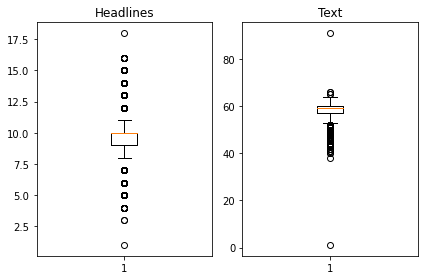

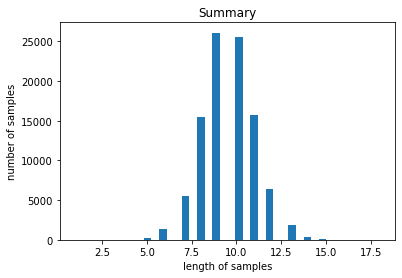

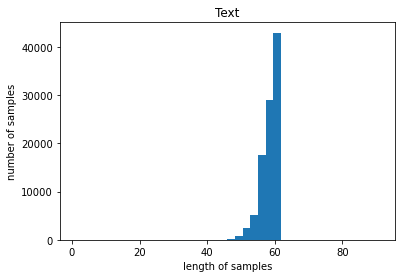

In [20]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
text_max_len = 60
summary_max_len = 12

In [22]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [23]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


In [24]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 95838


### 시작 토큰과 종료 토큰 추가하기

In [25]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


In [26]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [27]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[28499 61640  9677 ... 11612 30685 63406]


In [28]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [29]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19167


In [30]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


## 정수 인코딩

### 단어 집합 만들기 및 정수 인코딩

#### 훈련데이터 토크나이징

In [31]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 90382
등장 빈도가 6번 이하인 희귀 단어의 수: 65885
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24497
단어 집합에서 희귀 단어의 비율: 72.8961518886504
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.774991795308997


In [33]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[19, 1, 342, 872, 16598, 12355, 6, 398, 2, 1264, 398, 1546, 19, 3, 1784, 1999, 95, 60, 285, 247, 10, 109, 189, 124, 1075, 2, 5444, 873, 5, 17308, 2371, 2, 1, 482, 398, 1435, 1075, 4366, 18118, 10701, 1, 693, 1928, 8750, 1, 7030, 858, 2, 5444, 873, 15, 13916, 1, 7031, 505, 244, 7107, 14, 140], [39, 23, 1639, 1, 1261, 5, 400, 9861, 551, 4891, 1460, 7, 2304, 9862, 4, 1959, 1, 9862, 6094, 327, 729, 4, 84, 73, 13, 1, 115, 193, 5094, 15410, 7385, 2, 4891, 2304, 1, 1460, 1444, 2, 19016, 18119, 3954, 6, 2304, 7, 3, 551, 822], [3, 720, 207, 631, 2993, 3035, 12, 3492, 4, 24, 11166, 5240, 1140, 15411, 2657, 4, 4703, 7, 159, 4, 3, 1681, 236, 3, 5907, 12, 191, 4, 24, 2061, 16, 207, 656, 4, 1, 1857, 19017, 329, 1, 1516, 377, 3, 104, 501, 5, 1, 48, 2612, 5, 2686, 9, 1, 392, 283, 7, 121]]


#### headline데이터에 대해서도 토큰화 진행

In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 40412
등장 빈도가 5번 이하인 희귀 단어의 수: 29253
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11159
단어 집합에서 희귀 단어의 비율: 72.38691477778877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.3324679365635


In [37]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 23, 927, 1379, 6, 2306, 4, 2619, 1025, 88], [1, 12, 3, 993, 192, 634, 6412, 1436, 4, 1655], [1, 34, 1350, 1701, 34, 3912, 75, 69, 175, 4249, 243], [1, 551, 477, 48, 535, 477, 408, 7, 570, 4250, 168, 254], [1, 473, 4401, 515, 132, 5, 2620, 255, 64, 2224]]
target
decoder  [[23, 927, 1379, 6, 2306, 4, 2619, 1025, 88, 2], [12, 3, 993, 192, 634, 6412, 1436, 4, 1655, 2], [34, 1350, 1701, 34, 3912, 75, 69, 175, 4249, 243, 2], [551, 477, 48, 535, 477, 408, 7, 570, 4250, 168, 254, 2], [473, 4401, 515, 132, 5, 2620, 255, 64, 2224, 2]]


#### 데이터 정제

In [38]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


#### 패딩 

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

#  어텐션 메커니즘 적용

### 인코더 설계

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더 설계

In [41]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [42]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

### 어텐션 매커니즘 적용

In [43]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [44]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

# 모델 훈련

In [45]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
300/300 [==============================] - 117s 390ms/step - loss: 5.7999 - val_loss: 5.3887
Epoch 2/50
300/300 [==============================] - 119s 396ms/step - loss: 5.2428 - val_loss: 5.0319
Epoch 3/50
300/300 [==============================] - 120s 399ms/step - loss: 4.8792 - val_loss: 4.7218
Epoch 4/50
300/300 [==============================] - 118s 393ms/step - loss: 4.6074 - val_loss: 4.5092
Epoch 5/50
300/300 [==============================] - 117s 389ms/step - loss: 4.3880 - val_loss: 4.3555
Epoch 6/50
300/300 [==============================] - 116s 388ms/step - loss: 4.1999 - val_loss: 4.2283
Epoch 7/50
300/300 [==============================] - 115s 382ms/step - loss: 4.0421 - val_loss: 4.1354
Epoch 8/50
300/300 [==============================] - 115s 383ms/step - loss: 3.9059 - val_loss: 4.0434
Epoch 9/50
300/300 [==============================] - 115s 384ms/step - loss: 3.7878 - val_loss: 3.9693
Epoch 10/50
300/300 [==============================] - 115s 382m

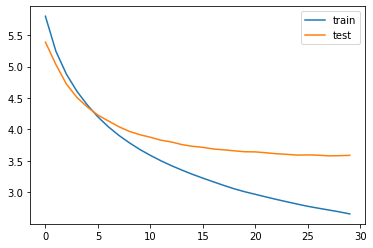

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 실제 결과와 요약문 비교

## 인퍼런스 모델 구현

In [48]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [49]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [50]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [52]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [53]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sunrisers hyderabad bowling coach muttiah muralitharan has said current sri lankan cricketers are not capable enough to play in the ipl australia new zealand south africa and england there are a lot of good players there the tournament can have 32 international players our guys don't fit into it we had great players but they all retired said muralitharan 
실제 요약 : sri lankan players not capable enough to play in ipl murali 
예측 요약 :  will play the new pitch in india laxman


원문 : the delhi government has registered a case against online booking platform for issuing tickets on buses running illegally in the city a spokesperson has claimed that the portal is merely an between the marketplace and consumers and that the bus operators listed on its website provide an undertaking that they have the requisite permits and licences 
실제 요약 : delhi govt takes to court for listing illegal buses 
예측 요약 :  delhi govt files complaint against aap for payment of payment


원문 : haq's nephew imam ul h

예측 요약 :  hc dismisses bail plea in law case against cbi


원문 : star india's video streaming service has denied reports claiming it is in talks with e commerce giant flipkart for a stake sale as as we are by the rumours the service is too valuable for such to be even entertained a spokesperson said no such conversation is happening with flipkart or any others the spokesperson added 
실제 요약 : denies reports claiming flipkart may buy a stake 
예측 요약 :  indian star denies reports of not making flipkart stake in flipkart


원문 : chennai's jigsaw radha shekhar has written to pm narendra modi urging him to address issues of funding and transparent business models at earliest radha said it was needed to avoid any suffering to women entrepreneurs like her at the hands of startups notably jigsaw accused startup stayzilla of defrauding payments resulting in its co founder yogendra arrest 
실제 요약 : client with unpaid dues writes to pm modi 
예측 요약 :  pm modi asks pm modi to not afraid of


원문 : bigg bo

예측 요약 :  football football club to be named after death


원문 : while the opposition in india has raised doubts over the reliability of evms russia has sought india's evm technology for 2018 presidential elections a report has claimed during the uttarakhand assembly polls deputy chairman of the russian election commission had visited the state to closely monitor the functioning of evms and the process 
실제 요약 : russia seeks india's evm technology for 2018 polls report 
예측 요약 :  opposition to probe into russian presidential election


원문 : a man who made ã¢ââ¹3 crore from selling his land was rescued from kidnappers after the sunglasses they made him wear at night reportedly the police's suspicion the sunglasses were being used to conceal the on the victim police were also suspicious when they noted the car being used in the crime was a taxi with white plates 
실제 요약 : cops rescue man as make him wear at night 
예측 요약 :  man finds ã¢ââ¹3 cr from stomach after stomach


원문 : on sunday midn

# Summa을 이용해서 추출적 요약해보기

In [54]:
import requests
from summa.summarizer import summarize

In [64]:
input_text = data['text']
print(input_text[:1500])

1       Kunal Shah's credit card bill payment platform...
2       New Zealand defeated India by 8 wickets in the...
3       With Aegon Life iTerm Insurance plan, customer...
5       Pakistani singer Rahat Fateh Ali Khan has deni...
7       Weeks after ex-CBI Director Alok Verma told th...
                              ...                        
1600    France has triggered a plan for a no-deal Brex...
1601    Chinese TV programmes appeared to be censoring...
1603    Canada's 67-year-old poker player Scott Wellen...
1606    Washington's 27-year-old Nick Naydev jumped st...
1608    Citing an investigative news report, Congress ...
Name: text, Length: 1500, dtype: object


In [58]:
input_text[10]

"Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture."

In [86]:
for _ in range(10) :
    rnum = np.random.randint(len(input_text))
    print(f'Original Sentence:\n{input_text[rnum]}\n')
    print(f'Summary:\n{summarize(input_text[rnum], ratio=0.4)}')
    print('--'*50+'\n\n')

Original Sentence:
The Deputy President of the UK Supreme Court, Brenda Hale, will be elevated to the position of the court's President in October, making her the first female to head UK's highest court. Hale, who joined the Supreme Court in 2009, will earn ÃÂ£225,000 a year as the President. She had earlier served as a counsel to Queen Elizabeth.

Summary:
The Deputy President of the UK Supreme Court, Brenda Hale, will be elevated to the position of the court's President in October, making her the first female to head UK's highest court.
----------------------------------------------------------------------------------------------------


Original Sentence:
A 'tree wall' of nearly 31 lakh native trees will soon encircle Delhi to protect it from dust storms coming from Rajasthan, a senior official of Union Ministry of Forest, Environment and Climate Change said. The government has already begun work of planting saplings. The tree wall will come along Delhi border with Haryana, Rajasth